In [1]:
import pandas as pd
import numpy as np
import os
import sys
import elephant.statistics as es
import neo
import quantities as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def convert_elno_to_xy(elno):
    chipWidth = 220
    x = int(elno/chipWidth)
    y = elno % chipWidth
    return x,y

In [4]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart'

In [24]:
filename = 'ID2184_7_DIV32_DATE20250415_1207_spontaneous_Freq_variation_try_2.raw.h5'
PROCESSED_DATA_PATH = os.path.join(MAIN_PATH, 'Sorters_stimulation/250415_stimulation')
PAIRINGS_PATH = os.path.join(MAIN_PATH, 'biTE_stimulation/250415_stimulation/Full_files')

In [25]:
data = np.load(os.path.join(PROCESSED_DATA_PATH, f'{filename[:-3]}_processed.pkl'), allow_pickle=True) 
data_te = np.load(os.path.join(PAIRINGS_PATH, f'{filename[:-3]}_processed_info_metrics.pkl'), allow_pickle=True)

In [26]:
unit_pre = 68
unit_post = 18

In [27]:
unit_ids = list(data['UNIT_TO_EL'].keys())
exp_duration = data['EXPERIMENT_DURATION']
unit_pre_idx = unit_ids.index(unit_pre)
unit_post_idx = unit_ids.index(unit_post)
unit_pre_idx, unit_post_idx

(37, 7)

In [28]:
mask = (data_te['mTE']['target'].astype(int) == unit_ids.index(unit_post)) & \
    (data_te['mTE']['source'].astype(int) == unit_ids.index(unit_pre))
print(f"mTE value: {data_te['mTE']['te'][mask][0]}")

mTE value: 0.003285443177446723


In [29]:
unit_locations = np.load(os.path.join(PROCESSED_DATA_PATH, f'Sorter_{filename}/wf_folder_curated/unit_locations/unit_locations.npy'))


In [30]:
unit_location_pre = unit_locations[unit_pre_idx][:2]
unit_location_post = unit_locations[unit_post_idx][:2]
unit_location_pre, unit_location_post
distance = np.sqrt((unit_location_pre[0]-unit_location_post[0])**2 + (unit_location_pre[1] - unit_location_post[1])**2)
print(f"Distance between electrodes: {distance}")

Distance between electrodes: 1393.6786855693963


In [31]:
data['SPIKEMAT_EXTREMUM']

array([('7392', 1.905000e+01,  11), ('8037', 2.760000e+01,   9),
       ('4076', 3.265000e+01,  73), ..., ('9161', 9.591245e+04, 107),
       ('11361', 9.591955e+04,  67), ('13562', 9.591955e+04, 116)],
      dtype=[('Electrode', '<U10'), ('Spike_Time', '<f8'), ('UnitIdx', '<i4')])

In [32]:
unit_pre_spikes = data['SPIKEMAT_EXTREMUM'][data['SPIKEMAT_EXTREMUM']['UnitIdx'] == unit_pre_idx]
unit_post_spikes = data['SPIKEMAT_EXTREMUM'][data['SPIKEMAT_EXTREMUM']['UnitIdx'] == unit_post_idx]

In [33]:
firing_rate_pre = len(unit_pre_spikes)/exp_duration
firing_rate_post = len(unit_post_spikes)/exp_duration
print(f"Firing rate pre: {firing_rate_pre}, firing rate post {firing_rate_post}")

Firing rate pre: 1.5325271059216012, firing rate post 5.660967472894078


In [34]:
#locations
unit_pre_electrode = int(np.unique(unit_pre_spikes['Electrode'])[0])
unit_pre_electrode_location = convert_elno_to_xy(unit_pre_electrode)
unit_pre_electrode_location

(11, 117)

In [50]:
relevant = pd.DataFrame(data_te['validated_results'])
relevant = relevant[relevant['source_unit_id'] == unit_pre]
relevant = relevant[relevant['target_unit_id'] == unit_post]
print(f"Synaptic probability: {relevant['syn probability'].values[0]}")

Synaptic probability: 0.7278911564625851


In [44]:
latency_extremum_row = relevant['latency_extremum'].iloc[0]
#latency_extremum_row


In [45]:
spike_times_pre = unit_pre_spikes['Spike_Time']
spike_times_post = unit_post_spikes['Spike_Time']
#spike_times_pre

In [46]:
#Calculating probabilities
# Convert to Neo SpikeTrain with correct units
def plot_prob_of_spiking(spike_times_ms,unit):

    t_stop = max(spike_times_ms) + 100  # Adding buffer in ms
    spiketrain = neo.SpikeTrain(spike_times_ms * pq.ms, t_stop=t_stop * pq.ms)

    # Now the functions will work with the correct time scale
    mean_rate = es.mean_firing_rate(spiketrain)

    # For firing probability estimation, also use ms units
    kernel = es.kernels.GaussianKernel(sigma=1000 * pq.ms)  # 1 s kernel width
    sampling_period = 10 * pq.ms  # 10 ms bins
    firing_probability = es.instantaneous_rate(spiketrain, sampling_period, kernel=kernel)
    time_in_seconds = np.arange(firing_probability.shape[0]) * sampling_period.rescale('s').magnitude
    plt.plot(time_in_seconds, firing_probability[:, 0])
    plt.title(f'Firing Probability {unit}')
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Probability')
    plt.show()
    return

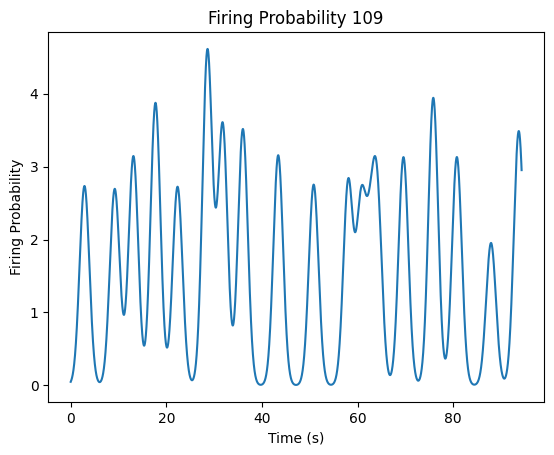

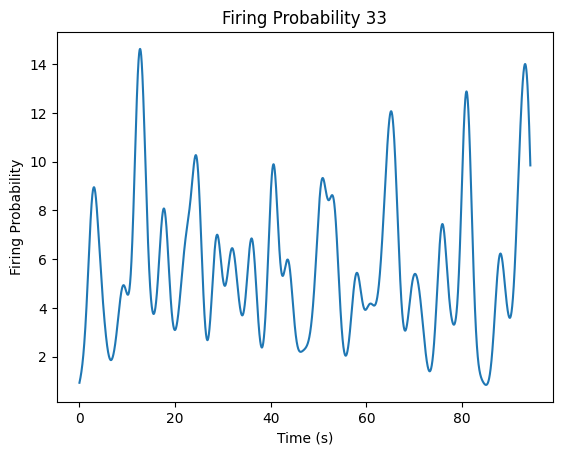

In [47]:
plot_prob_of_spiking(spike_times_pre, unit_pre)
plot_prob_of_spiking(spike_times_post, unit_post)
# Plotting the spike trains

In [48]:
def analyze_latency_data(df):
    """
    Analyze latency_extremum dataframe to calculate:
    1. Count of 'output' rows per input spike index
    2. Percentage of 'output' rows per input spike index
    3. Binned counts over time (1000ms bins)
    
    Args:
        df: pandas DataFrame with columns 'input spike', 'spike time', 'latency', 'category'
    
    Returns:
        Dictionary with analysis results and plots
    """
    # Ensure column names are standardized (replace spaces with underscores)
    df.columns = [col.replace(' ', '_') for col in df.columns]
    
    # Step 1: Count output spikes for each input spike index
    output_counts = df[df['category'] == 'output'].groupby('input_spike').size()
    total_counts = df.groupby('input_spike').size()
    
    # Step 2: Calculate percentage of outputs per input spike
    output_percentage = (output_counts / total_counts * 100).fillna(0)
    
    # Convert spike time from milliseconds to seconds for plotting
    df['time_seconds'] = df['spike_time'] / 1000
    
    # Step 3: Bin by time (1 second intervals)
    min_time_sec = df['time_seconds'].min()
    max_time_sec = df['time_seconds'].max()
    
    # Create finer bins for a smooth curve (0.5 second bins)
    num_bins = int((max_time_sec - min_time_sec) * 0.5) # 1 bins per second
    bins = np.linspace(min_time_sec, max_time_sec, num_bins + 1)
    
    # Create bins and calculate percentages in each bin
    df['time_bin'] = pd.cut(df['time_seconds'], bins=bins, right=False)
    
    # For each time bin, calculate the percentage of outputs
    time_bin_stats = df.groupby('time_bin')['category'].apply(
        lambda x: 100 * (x == 'output').sum() / len(x)
    ).fillna(0)
    
    # Convert the index to numeric values for plotting (midpoint of each bin)
    bin_centers = np.array([(b.left + b.right) / 2 for b in time_bin_stats.index])
    
    # Create visualization - just one plot showing percentage over time
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Plot the percentage over time with a smooth curve
    ax.plot(bin_centers, time_bin_stats.values, linewidth=2)
    
    # Add a trend line using Savitzky-Golay filter for smoothing
    from scipy.signal import savgol_filter
    if len(time_bin_stats) > 7:  # Need enough points for the filter
        yhat = savgol_filter(time_bin_stats.values, 
                            min(7, len(time_bin_stats) // 2 * 2 + 1), # Must be odd and <= len
                            3)
        ax.plot(bin_centers, yhat, 'r--', linewidth=1, alpha=0.6)
    
    ax.set_title('Output Firing If Input Firing Over Time')
    ax.set_xlabel('Time (s)')
    ax.set_ylim(0, 100)
    ax.set_ylabel('Output Percentage (%)')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # Return the results
    results = {
        'output_counts': output_counts,
        'output_percentage': output_percentage,
        'time_binned_percentage': time_bin_stats,
    }
    
    return results, fig

/tmp/ipykernel_5285/2356022505.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_bin_stats = df.groupby('time_bin')['category'].apply(
/tmp/ipykernel_5285/2356022505.py:40: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: 100 * (x == 'output').sum() / len(x)


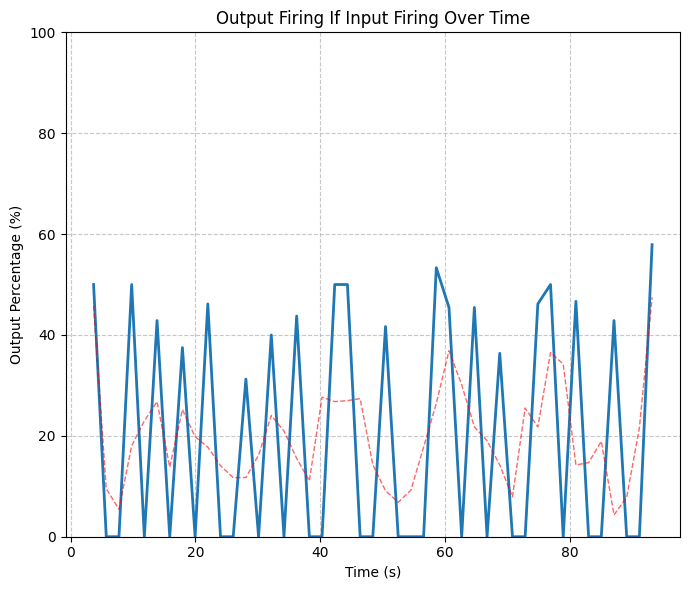

In [49]:
results, figure = analyze_latency_data(pd.DataFrame(latency_extremum_row))